# Introduction

### Goal

The goal is to forecast twelve-hours of traffic flow in a U.S. metropolis. <br>
A time series dataset that are labelled with both location coordinates & direction of travel. 

### Metric

Submissions will be evaluated on the `mean absolute error` between predicted and actual congestion values for each time period in the test set.<br>The target has a range from 0 to 100.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd
pd.options.display.max_columns = None #Helps with showing all columns in a dataframe

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator #helps with plotting tickers

import seaborn as sns

mpl.rcParams['axes.facecolor'] = '#222222'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.bottom'] = False

plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
train = pd.read_csv("../input/tabular-playground-series-mar-2022/train.csv")
test = pd.read_csv("../input/tabular-playground-series-mar-2022/test.csv")
print("--Done--")

In [ ]:
train.sample(3)

In [ ]:
print(f'Shape of train: {train.shape}')
print(f'Shape of test:{test.shape}')
print('-'*20)
print(f'Null values in train: {train.isna().sum().sum()}')
print(f'Null values in test: {test.isna().sum().sum()}')

In [ ]:
train.describe().T

In [ ]:
print(f'Unqiue values in the "direction" column: {train["direction"].value_counts().count()}')
print(f'Unique values in the "x" column: {train["x"].value_counts().count()}')
print(f'Unique values in the "y" column: {train["y"].value_counts().count()}')

# Pre-processing the Data

In [ ]:
train['date'] = pd.to_datetime(train['time'], format='%Y-%m-%d %H:%M:%S')

train['year'] = pd.DatetimeIndex(train['date']).year
train['month'] = pd.DatetimeIndex(train['date']).month
train['day'] = pd.DatetimeIndex(train['date']).day

train['hour'] = pd.DatetimeIndex(train['date']).hour
train['min'] = pd.DatetimeIndex(train['date']).minute
train['secs'] = pd.DatetimeIndex(train['date']).second
train['week'] = pd.DatetimeIndex(train['date']).weekday
train['week_yr'] = pd.DatetimeIndex(train['date']).weekofyear

In [ ]:
train.drop('time', axis=1, inplace=True)
train.rename(columns={"date": "time"}, inplace=True)
train.sample(4)

# Basic EDA

> **Note:** Please check the y-axis while reading graphs, this EDA has quite a lot of line charts which don't always start from zero.

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5), facecolor='#2b2b2b')
ax.tick_params(axis='x', colors='gray', size=8)
ax.tick_params(axis='y', colors='gray', size=8)
sns.histplot(train, x='congestion', kde=True, bins=100, line_kws={'linewidth': 3}, color='skyblue', alpha=0.7)
ax.lines[0].set_color('crimson')
ax.set_xlabel('Congestion', fontsize=16, color='yellow',labelpad=20)
ax.set_ylabel('Count', fontsize=16, color='yellow',labelpad=20)
ax.set_title('Distribution of Congestion', color='yellow', fontsize=20, pad=20)
ax.grid(alpha=0.2, ls=':')
plt.show()

**Notes**:

- The distribution is normal as it has been normalized, (mentioned in the data section)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5), facecolor='#2b2b2b')
ax.tick_params(axis='x', colors='gray', size=8)
ax.tick_params(axis='y', colors='gray', size=8)
sns.histplot(train, x='direction', color='skyblue', alpha=0.7)
ax.set_xlabel('Congestion', fontsize=16, color='yellow',labelpad=20)
ax.set_ylabel('Count', fontsize=16, color='yellow',labelpad=20)
ax.set_title('Distribution of Congestion', color='yellow', fontsize=20, pad=20)
ax.grid(alpha=0.2, ls=':')
plt.show()

### Weekly Congestion

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5), facecolor='#2b2b2b')
ax.tick_params(axis='x', colors='gray', size=8)
ax.tick_params(axis='y', colors='gray', size=8)
sns.lineplot(x=train.week, y=train.congestion, color='skyblue', alpha=0.8, linewidth=3)
ax.set_xlabel('Weekday (0:Monday -- 6:Sunday)', fontsize=16, color='lightcoral',labelpad=20)
ax.set_ylabel('Congestion', fontsize=16, color='lightcoral',labelpad=20)
ax.set_title('Relation between Congestion vs Weekday', color='lightcoral', fontsize=20, pad=20)
ax.grid(alpha=0.2, ls='-.')
plt.show()

We see a drastic dip around the weekends, which is an expected behaviour.

### Monthly congestion

In [ ]:
monthwise = train.groupby('month').mean().reset_index()

fig, ax = plt.subplots(figsize=(20, 5), facecolor='#2b2b2b')
ax.tick_params(axis='x', colors='gray', size=8)
ax.tick_params(axis='y', colors='gray', size=8)
sns.lineplot(x=monthwise.month, y=monthwise.congestion, color='skyblue', alpha=0.8, linewidth=3)
ax.set_xlabel('Month', fontsize=16, color='lightcoral',labelpad=20)
ax.set_ylabel('Congestion', fontsize=16, color='lightcoral',labelpad=20)
ax.set_title('Relation between Congestion vs Month', color='lightcoral', fontsize=20, pad=20)
ax.grid(alpha=0.2, ls='-.')
plt.show()

### Daily congestion based on Month

In [ ]:
day_04 = train[train['month'] == 4].groupby(['day']).mean().reset_index()
day_05 = train[train['month'] == 5].groupby(['day']).mean().reset_index()
day_06 = train[train['month'] == 6].groupby(['day']).mean().reset_index()
day_07 = train[train['month'] == 7].groupby(['day']).mean().reset_index()
day_08 = train[train['month'] == 8].groupby(['day']).mean().reset_index()
day_09 = train[train['month'] == 9].groupby(['day']).mean().reset_index()

day_list = {
    'April': day_04, 
    'May': day_05, 
    'June': day_06,
    'July': day_07,
    'August': day_08, 
    'September': day_09,
           }

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(30, 20), facecolor='#2b2b2b')
plt.subplots_adjust(hspace=0.3)
i, j = 0, 0
for k in day_list:
    
    sns.lineplot(x=day_list[k].day, y=day_list[k].congestion, color='skyblue', alpha=0.8, linewidth=3, ax=ax[j][i])
    ax[j][i].tick_params(axis='x', colors='gray', size=8)
    ax[j][i].tick_params(axis='y', colors='gray', size=8)
    ax[j][i].set_xlabel('Day', fontsize=16, color='lightcoral',labelpad=20)
    ax[j][i].set_ylabel('Congestion', fontsize=16, color='lightcoral',labelpad=20)
    ax[j][i].set_title(f'Congestion trend each Day in {k}', color='lightcoral', fontsize=18, pad=20)
    ax[j][i].grid(alpha=0.2, ls='-.')
    
    i += 1
    if i == 2:
        j += 1
        i = 0
        
fig.tight_layout()
plt.show()

**Notes:**

- The V-shaped dips are results of Weekends.

### Congestion based on Week of Year

In [ ]:
weekday = train.groupby('week_yr').mean().reset_index()


fig, ax = plt.subplots(figsize=(20, 5), facecolor='#2b2b2b', dpi=100)
ax.tick_params(axis='x', colors='gray', size=8)
ax.tick_params(axis='y', colors='gray', size=8)
sns.lineplot(x=weekday.week_yr, y=weekday.congestion, color='skyblue', alpha=0.8, linewidth=3)
ax.set_xlabel('Week of Year', fontsize=16, color='lightcoral',labelpad=20)
ax.set_ylabel('Congestion', fontsize=16, color='lightcoral',labelpad=20)
ax.set_title('Relation between Congestion vs Week of Year', color='lightcoral', fontsize=20, pad=20)
ax.grid(alpha=0.2, ls=':')
plt.show()

**Notes:**

> We see that on Week 40 there is a massive dip in congestion. Upon checking, it seems that Week 40 started on September 30,1991. Techincally saying we have only one single day of data.

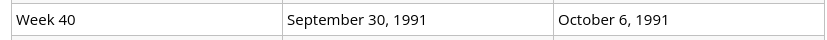

### Hourly Congestion

In [ ]:
allday = train.groupby('hour').mean().reset_index()

fig, ax = plt.subplots(figsize=(20, 5), facecolor='#2b2b2b', dpi=100)
ax.tick_params(axis='x', which='both', colors='gray', size=8)
ax.tick_params(axis='y', colors='gray', size=8)
sns.lineplot(x=allday.hour, y=allday.congestion, color='skyblue', alpha=0.8, linewidth=3)
ax.set_xlabel('Hour', fontsize=16, color='lightcoral',labelpad=20)
ax.set_ylabel('Congestion', fontsize=16, color='lightcoral',labelpad=20)
ax.set_title('Relation between Congestion vs Hour', color='lightcoral', fontsize=20, pad=20)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(alpha=0.2, ls=':')
plt.show()

The congestion starts rising around the 6:00 hour mark hitting a minor high at 8:00 hour mark while rising gradually after that to a peak congestion at around 17:00 hour mark.

### Unique Directions

In [ ]:
locator = train.groupby(['x', 'y', 'direction']).mean().reset_index()
y_mean = locator.congestion.mean()

fig, ax = plt.subplots(figsize=(30, 8), facecolor='#2b2b2b', dpi=100)
ax.tick_params(axis='x', which='both', colors='gray', size=8)
ax.tick_params(axis='y', colors='gray', size=8)
sns.lineplot(x=locator.index, y=locator.congestion, color='skyblue', alpha=0.8, linewidth=4)
plt.axhline(y=y_mean, xmin=0.04, xmax=0.96, color='crimson', linestyle='--', alpha=0.5, linewidth=3)
ax.set_xlabel('Unique Directions', fontsize=16, color='lightcoral',labelpad=20)
ax.set_ylabel('Congestion', fontsize=16, color='lightcoral',labelpad=20)
ax.set_title('Relation between Congestion vs Unique Directions', color='lightcoral', fontsize=20, pad=20)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(alpha=0.2, ls='-.')
ax.annotate('Mean Congestion', xy= (26, 47), color='hotpink', size=16, alpha=0.8, xytext=(29,40),
            arrowprops=dict(facecolor='white', arrowstyle='->', connectionstyle='arc3,rad=0.5', color='hotpink'),
            horizontalalignment='right', verticalalignment='top',
            )
plt.show()
locator[['x', 'y', 'direction']].T

**Notes**:
> (x, y, direction) - There seems to be 31 direction which are below the mean congestion & 34 which are above the mean congestion.

Lowest:
- (2, 3, SW) seems to have the average lowest congestion. 
- (2, 1, NE) seems to also have the average lowest congestion.
- (2, 2, NW) & (0, 1, EB) are the next to have lowest congestion.

---
Highest:
- (2, 3, SB) & (2, 0, WB) seems to have the average higest congestion.
- (0, 1, NB) seems to also have the average higest congestion.
- (2, 0, NB) & (2, 2, WB) are the next to have highest congestion.



# In-Depth EDA: A Dive into Congestion

In [ ]:
congestion_percent = (((train.congestion.value_counts())/train.shape[0]) * 100)

fig, ax = plt.subplots(figsize=(30, 5), facecolor='#2b2b2b', dpi=100)
ax.tick_params(axis='x', which='both', colors='gray', size=8)
ax.tick_params(axis='y', colors='gray', size=8)
sns.barplot(x=congestion_percent.index, y=congestion_percent.values, color='skyblue', alpha=0.8, linewidth=3)
ax.set_xlabel('Congestion', fontsize=16, color='lightcoral',labelpad=20)
ax.set_ylabel('Percentage', fontsize=16, color='lightcoral',labelpad=20)
ax.set_title('Percentage of Congestion', color='lightcoral', fontsize=20, pad=20)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(alpha=0.2, ls=':')
plt.show()

**Notes**:

- Congestion `34` occurs nearly ~3% of the entire dataset, with the most common on (2, 1, SE).
- Congestion `29` occurs nearly ~2% of the entire dataset, with the most common on (2, 1, NW).
- Congestion `21` occurs nearly ~1.8% of the entire dataset, with the most common on (2, 2, NW).

These are the standouts, while everything else falls under a normal distribution.

- Congestion `99` occurs the lowest with only ~0.004% 
- Congestion `1`  occurs the lowest with only ~0.005%
- Congestion `98` occurs the lowest with only ~0.010%

### Most occuring congestion value based on Unique Directions

In [ ]:
congestion_mode = train.groupby(['x', 'y', 'direction']).agg(lambda x:x.value_counts().index[0]).reset_index()
congestion_mcom = congestion_mode.congestion.value_counts().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(20, 5), facecolor='#2b2b2b', dpi=100)
ax.tick_params(axis='x', which='both', colors='gray', size=8)
ax.tick_params(axis='y', colors='gray', size=8)
sns.barplot(x=congestion_mcom.index, y=congestion_mcom.values, color='skyblue', alpha=0.8, linewidth=3)
ax.set_xlabel('Congestion', fontsize=16, color='lightcoral',labelpad=20)
ax.set_ylabel('Number of Directions', fontsize=16, color='lightcoral',labelpad=20)
ax.set_title('Mode of Congestion based on Direction', color='lightcoral', fontsize=20, pad=20)
ax.text(x=2.5, y=3.8, s="Way to read:\n\n'Out of 65 different directions, congestion \nvalue 38 occurs in five different direction \nwhile being the highest value in each direction'", color='hotpink')
ax.grid(alpha=0.2, ls=':')
plt.show()

**Notes**:

- Congestion `38` occurs the highest number of time in (0, 2, WB), (1, 0, SB), (1, 0, WB), (1, 3, EB), (2, 1, SB).
- Congestion `51` occurs the highest number of time in (0, 3, WB), (1, 0, NB), (1, 2, NE), (2, 1, WB).
---
You can view the mode of each individual direction by using `congestion_mode`.

### Congestion on Unique Directions Monthly

In [ ]:
april = train[train.month == 4].groupby(['x', 'y', 'direction',]).mean().reset_index()
may = train[train.month == 5].groupby(['x', 'y', 'direction',]).mean().reset_index()
june = train[train.month == 6].groupby(['x', 'y', 'direction',]).mean().reset_index()
july = train[train.month == 7].groupby(['x', 'y', 'direction',]).mean().reset_index()
august = train[train.month == 8].groupby(['x', 'y', 'direction',]).mean().reset_index()
september = train[train.month == 9].groupby(['x', 'y', 'direction',]).mean().reset_index()

month_list = {
    'April': april, 
    'May': may, 
    'June': june,
    'July': july,
    'August': august, 
    'September': september,
           }

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(30, 20), facecolor='#2b2b2b')
plt.subplots_adjust(hspace=0.3)
i, j = 0, 0
for k in day_list:
    
    sns.lineplot(x=month_list[k].index, y=month_list[k].congestion, color='skyblue', alpha=0.8, linewidth=3, ax=ax[j][i])
    ax[j][i].tick_params(axis='x', colors='gray', size=8)
    ax[j][i].tick_params(axis='y', colors='gray', size=8)
    ax[j][i].set_xlabel('Unique Direction', fontsize=16, color='lightcoral',labelpad=20)
    ax[j][i].set_ylabel('Congestion', fontsize=16, color='lightcoral',labelpad=20)
    ax[j][i].set_title(f'Congestion trend with each unique direction in {k}', color='lightcoral', fontsize=18, pad=20)
    ax[j][i].grid(alpha=0.2, ls='-.')
    
    i += 1
    if i == 2:
        j += 1
        i = 0
fig.tight_layout()
plt.show()

Notes:

- They look pretty much the same, with minor to no fluctuations.
- You can refer to the **Notes** under the *Unique Directions*, right above In-Depth EDA.

### Hourly congestion based on Day

In [ ]:
mon = train[train.week == 0].groupby('hour').mean().reset_index()
tue = train[train.week == 1].groupby('hour').mean().reset_index()
wed = train[train.week == 2].groupby('hour').mean().reset_index()
thu = train[train.week == 3].groupby('hour').mean().reset_index()
fri = train[train.week == 4].groupby('hour').mean().reset_index()
sat = train[train.week == 5].groupby('hour').mean().reset_index()
sun = train[train.week == 6].groupby('hour').mean().reset_index()

week_list = {
    'Monday': mon, 
    'Tuesday': tue, 
    'Wednesday': wed,
    'Thrusday': thu,
    'Friday': fri, 
    'Saturday': sat,
    'Sunday': sun,
           }

fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(20, 20), facecolor='#2b2b2b')
plt.subplots_adjust(hspace=0.3)
i, j = 0, 0
for k in week_list:
    
    sns.lineplot(x=allday.hour, y=allday.congestion, color='skyblue', alpha=0.8, linewidth=3, ax=ax[j][i], label='All day Average')
    sns.lineplot(x=week_list[k].hour, y=week_list[k].congestion, color='sandybrown', alpha=0.8, linewidth=3, ax=ax[j][i], 
                 label=f'Only {k} average')
    ax[j][i].tick_params(axis='x', colors='gray', size=8)
    ax[j][i].tick_params(axis='y', colors='gray', size=8)
    ax[j][i].set_xlabel('Hour', fontsize=16, color='lightcoral',labelpad=20)
    ax[j][i].set_ylabel('Congestion', fontsize=16, color='lightcoral',labelpad=20)
    ax[j][i].set_title(f'Congestion trend with each hour on {k} compared to all day average', color='lightcoral', fontsize=18, pad=20)
    ax[j][i].grid(alpha=0.2, ls='-.')
    ax[j][i].legend(labelcolor='linecolor')
    
    i += 1
    if i == 2:
        j += 1
        i = 0
fig.delaxes(ax[3][1])
fig.tight_layout()
plt.show()

**Notes**:

- Friday seems to have a high congestion. (Prior to the weekend maybe?)
- Tuesday and Thrusday seem to have a high congestion too with a close Wednesday. Monday seems to be compartively less.
- Sunday are pretty much No-congestion days
- Saturday are interesting ones, with small rise in congestion above mean around the start of the day.

### Daily congestion based on Month

In [ ]:
all_week = train.groupby('week').mean().reset_index()
week_04 = train[train['month'] == 4].groupby(['week']).mean().reset_index()
week_05 = train[train['month'] == 5].groupby(['week']).mean().reset_index()
week_06 = train[train['month'] == 6].groupby(['week']).mean().reset_index()
week_07 = train[train['month'] == 7].groupby(['week']).mean().reset_index()
week_08 = train[train['month'] == 8].groupby(['week']).mean().reset_index()
week_09 = train[train['month'] == 9].groupby(['week']).mean().reset_index()

z_list = {
    'April': week_04, 
    'May': week_05, 
    'June': week_06,
    'July': week_07,
    'August': week_08, 
    'September': week_09,
           }

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(20, 15), facecolor='#2b2b2b')
plt.subplots_adjust(hspace=0.3)
i, j = 0, 0
for k in day_list:
    
    sns.lineplot(x=all_week.week, y=all_week.congestion, color='skyblue', alpha=0.8, linewidth=3, ax=ax[j][i], 
                 label='All weekday Average')    
    sns.lineplot(x=z_list[k].week, y=z_list[k].congestion, color='sandybrown', alpha=0.8, linewidth=3, ax=ax[j][i], 
                 label=f'{k} weekday average')
    ax[j][i].tick_params(axis='x', colors='gray', size=8)
    ax[j][i].tick_params(axis='y', colors='gray', size=8)
    ax[j][i].set_xlabel('Weekday', fontsize=16, color='lightcoral',labelpad=20)
    ax[j][i].set_ylabel('Congestion', fontsize=16, color='lightcoral',labelpad=20)
    ax[j][i].set_title(f'Congestion trend each weekday average in {k} compared to all weekday average', color='lightcoral', 
                       fontsize=18, pad=20)
    ax[j][i].grid(alpha=0.2, ls='-.')
    ax[j][i].legend(labelcolor='linecolor')
    
    i += 1
    if i == 2:
        j += 1
        i = 0
        
fig.tight_layout()
plt.show()

### Week-39's congestion compared to all weekdays' congestion

In [ ]:
week_39 = train[train.week_yr == 39].groupby('week').mean().reset_index()
week_39

fig, ax = plt.subplots(figsize=(20, 5), facecolor='#2b2b2b', dpi=100)
ax.tick_params(axis='x', which='both', colors='gray', size=8)
ax.tick_params(axis='y', colors='gray', size=8)
sns.lineplot(x=all_week.week, y=all_week.congestion, color='skyblue', alpha=0.8, linewidth=3, ax=ax, label='All weekday congestion')    
sns.lineplot(x=week_39.week, y=week_39.congestion, color='sandybrown', alpha=0.8, linewidth=3, ax=ax, label='Week-39 congestion')
ax.set_xlabel('Weekday', fontsize=16, color='lightcoral',labelpad=20)
ax.set_ylabel('Congestion', fontsize=16, color='lightcoral',labelpad=20)
ax.set_title('Week-39 congestion compared to average of all weekday congestion', color='lightcoral', fontsize=20, pad=20)
ax.grid(alpha=0.2, ls=':')
ax.legend(labelcolor='linecolor')

plt.show()

### Average of Septmbers Mondays' with all other Mondays'

In [ ]:
sep_mon = train[(train['day'] == 23) | (train['day'] == 16) | (train['day'] == 9)].groupby('hour').mean().reset_index()
mon_23 = train[(train['day'] == 23)].groupby('hour').mean().reset_index()


fig, ax = plt.subplots(figsize=(20, 5), facecolor='#2b2b2b', dpi=100)
ax.tick_params(axis='x', which='both', colors='gray', size=8)
ax.tick_params(axis='y', colors='gray', size=8)
sns.lineplot(x=sep_mon.hour, y=sep_mon.congestion, color='sandybrown', alpha=0.8, linewidth=3, ax=ax, label='Last 3 Monday\'s Average',
            linestyle="--")
sns.lineplot(x=mon_23.hour, y=mon_23.congestion, color='skyblue', alpha=0.8, linewidth=2, ax=ax, label='Last Monday\'s Average',
            linestyle=":")
sns.lineplot(x=week_list['Monday'].hour, y=week_list['Monday'].congestion, color='mintcream', alpha=0.8, linewidth=4, ax=ax, 
             label=f'Only Mondays\' average', linestyle="-")
ax.set_xlabel('Hour', fontsize=16, color='lightcoral',labelpad=20)
ax.set_ylabel('Congestion', fontsize=16, color='lightcoral',labelpad=20)
ax.set_title('Last 3 Monday\'s compared to Last Monday & Only Mondays', color='lightcoral', fontsize=20, pad=20)
ax.grid(alpha=0.2, ls=':')
ax.legend(labelcolor='linecolor')
plt.show()

> Special mentions: 

- [AmbrosM Notebook](https://www.kaggle.com/ambrosm/tpsmar22-eda-which-makes-sense/notebook)
- [Sy-Tuan Nguyen Notebook](https://www.kaggle.com/sytuannguyen/tps-mar-2022-eda-model#Goal)


Feedback and comments are highly appreciated. <br>